In [1]:
%cd ../

/home/renan/git/KDD-Enade-Computing


In [2]:
import pandas as pd
import numpy as np
from src import util
from src.transformation import transform
from src import config
from src import subject_manipulation
from typing import Tuple, List
from src.config import SUBJECT_DF_PATH, BLANK_ANSWER_LABEL, DELETION_ANSWER_LABEL, CANCELLED_LABEL, DIFFICULTIES, \
    MATH_SUBJECTS, COMPUTING_SUBJECTS, HUMAN_SUBJECTS, TECHNOLOGY_SUBJECTS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches


In [3]:
CODE_COURSE = "12025"

In [4]:
years = [2017, 2014, 2011, 2008, 2005]

In [5]:
def read_csv_course(year, filter_by_course):
    df = transform.read_csv(year)
    if filter_by_course:
        df = df.loc[df["CO_CURSO"] == CODE_COURSE]
    return df

In [6]:
subject_df = subject_manipulation.get_processed_subject_df(SUBJECT_DF_PATH)

In [7]:
def get_display_df(year: int, input_df: pd.DataFrame,
                   subject_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    temp_subject_df = subject_df.loc[subject_df['ano'] == year].copy()
    
    util.map_presence(input_df)
    presence_df = input_df["TP_PRES"].value_counts()
    
    input_df = util.filter_present_students(input_df)
    subjects = util.get_subjects(temp_subject_df)
    input_df = util.add_all_score_categories(input_df, temp_subject_df, True, 
                                           subjects, util.get_subject_valid_questions)
    
    num_questions = []
    mean_acertos_by_subject = []
    std_acertos_by_subject = []
    column_zero_subject = []
    column_geq_one_subject = []
    column_all_subject = []
    num_alunos = input_df.shape[0]

    

    
    for subject in subjects:
        subject_questions = util.get_subject_valid_questions(subject, 
                                                                 temp_subject_df,
                                                                 input_df,
                                                                 just_objective=True)
        num_obj_subject_questions = len(subject_questions)
    
    
    
        mean_acertos_subject = input_df[f"ACERTOS_OBJ_{subject}"].mean()
    
        std_acertos_subject = input_df[f"ACERTOS_OBJ_{subject}"].std()
    
        zero_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"]).count(0) * 100 / num_alunos
    
        geq_one_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"] >= 1).count(True) * 100 / num_alunos
        
        all_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"] == num_obj_subject_questions).count(True) * 100 / num_alunos
        
        if num_obj_subject_questions > 0:
            num_questions.append(num_obj_subject_questions)
            mean_acertos_by_subject.append(mean_acertos_subject)
            std_acertos_by_subject.append(std_acertos_subject)
            column_zero_subject.append(zero_subject_percentage)
            column_geq_one_subject.append(geq_one_subject_percentage)
            column_all_subject.append(all_subject_percentage)
        else:
            num_questions.append(0)
            mean_acertos_by_subject.append(None)
            std_acertos_by_subject.append(None)
            column_zero_subject.append(None)
            column_geq_one_subject.append(None)
            column_all_subject.append(None)

    subjects_labels = [f"SCORE_OBJ_{x}" for x in subjects]

    mean_by_subject = input_df[subjects_labels].mean().values

    data = np.array([mean_by_subject, num_questions]).T

    display_df = pd.DataFrame(data=data, index=subjects, 
                          columns=["Nota %", "Nº Questões"])
    display_df["Nº Questões"] = display_df["Nº Questões"].astype(int, errors="ignore")
    display_df["Média Acertos"] = mean_acertos_by_subject
    display_df["Desvio Padrão Acertos"] = std_acertos_by_subject
    display_df["% de Zeros"] = column_zero_subject

    display_df["% de Alunos que acertaram pelo menos uma questão"] = column_geq_one_subject
    display_df["% de Alunos que acertaram todas"] = column_all_subject


    display_df = display_df.sort_values(by=["Nota %"]).round(2)

    
    return display_df, input_df, presence_df
    
    

In [8]:
def get_dict_all_years(filter_by_course: bool) -> dict:
        
    result = {}
    for year in years:
        result[year] = read_csv_course(year, filter_by_course=filter_by_course)
        
    return result

In [9]:
dfs = get_dict_all_years(filter_by_course=True)

In [10]:

display_dfs = {}
presence_dfs = {}
for year in dfs.keys():
    enade_df = dfs[year]
    display_df, df, presence_df = get_display_df(year, enade_df, subject_df)
    dfs[year] = df
    display_dfs[year] = display_df
    presence_dfs[year] = presence_df   
    

/home/renan/.pyenv/versions/3.6.9/envs/enade/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.pyenv/versions/3.6.9/envs/enade/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/renan/.pyenv/versions/3.6.9/envs/enade/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to

In [11]:
presence_by_year = {"2005": presence_dfs[2005].copy(),
                    "2008": presence_dfs[2008].copy(),
                    "2011": presence_dfs[2011].copy(),
                    "2014": presence_dfs[2014].copy(),
                    "2017": presence_dfs[2017].copy()}

presence_by_year_df = pd.DataFrame(presence_by_year)
presence_by_year_df.fillna(0).astype(int)


,2005,2008,2011,2014,2017
Presente,30,36,17,28,34
Ausente,5,2,3,3,14


In [12]:
import matplotlib as mlp
mlp.__version__

'3.3.4'

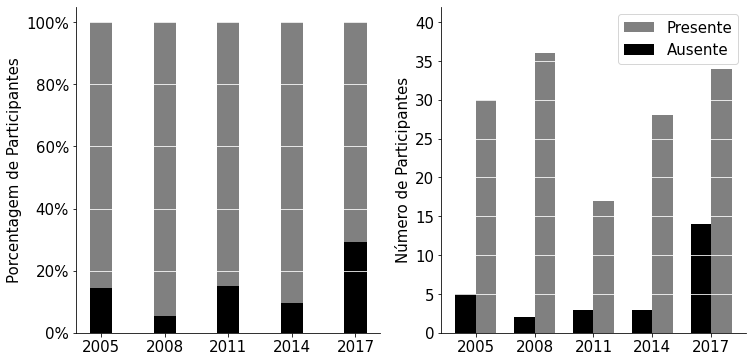

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams["figure.figsize"] = (12,6)
font = {
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

N = len(presence_by_year)
present = presence_by_year_df.loc["Presente"]
absent = presence_by_year_df.loc["Ausente"]
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


ax = plt.subplot(121)


p1 = ax.bar(ind,100* absent / (absent+present), width, label='Ausente', color="black")
p2 = ax.bar(ind,100* present / (absent+present), width,
            bottom=100*absent / (absent+present), label='Presente', color="gray")

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Porcentagem de Participantes')
ax.set_xticks(ind)
ax.grid(axis = 'y', color ='white', linestyle='-')

ax.set_xticklabels(('2005', '2008', '2011', '2014', '2017'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())


plt.savefig("/tmp/student_frequency", dpi=500)


ax = plt.subplot(122)

p2 = ax.bar(ind - width/2, absent, width, color="black")
p1 = ax.bar(ind + width/2, present, width, color="gray")


plt.ylabel('Número de Participantes')
#plt.title('Frequência de alunos por ano')
plt.xticks(ind, presence_by_year_df.columns)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Presente', 'Ausente'))
ax.grid(axis = 'y', color ='white', linestyle='-')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0,42)
#fig.tight_layout()
#ax.bar_label(rects1, padding=3)
# Label with label_type 'center' instead of the default 'edge'
#ax.bar_label(p1, label_type='center')
#ax.bar_label(p2, label_type='center')
#ax.bar_label(p2)


plt.savefig("/tmp/student_frequency", dpi=500)

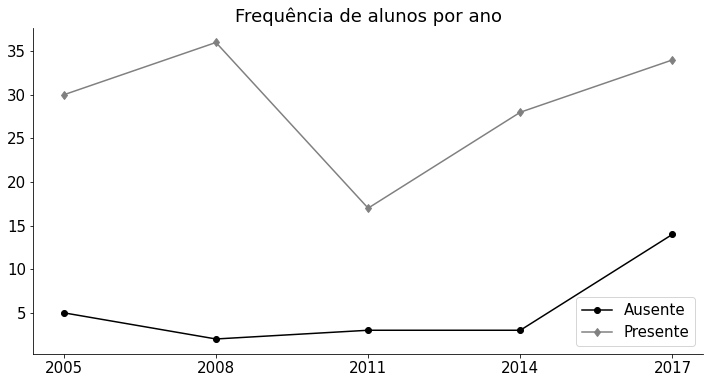

In [14]:
ax = plt.subplot(111)
plt.plot(absent,'o-', color="black", label="Ausente")
plt.plot(present,'d-', color="gray", label="Presente")
plt.legend()
plt.title('Frequência de alunos por ano')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

/home/renan/.pyenv/versions/3.6.9/envs/enade/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


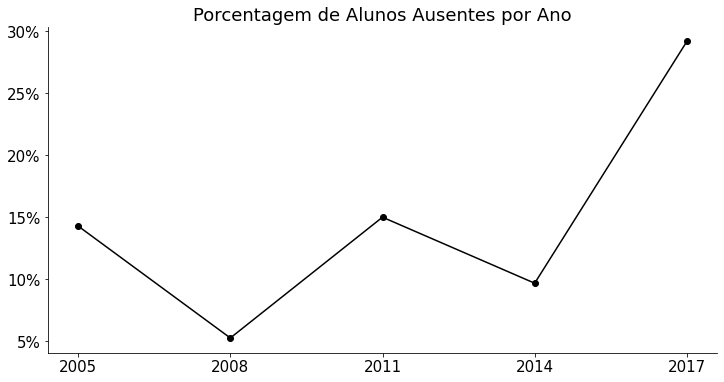

In [15]:
ax = plt.subplot(111)
plt.plot(absent / (present + absent),'o-', color="black")
plt.title('Porcentagem de Alunos Ausentes por Ano')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(x) for x in vals])
plt.show()

In [16]:
"""Numero de questões marcadas em branco e rasuradas. 
   
   A porcentagem desses valores é calculada de acordo com o numero total de questões da prova x o numero de
   alunos presentes
   
   Considera questões anuladas. Acho que faz sentido saber se um aluno deixou uma questão em branco mesmo sabendo
   se ela foi anulada depois"""


def get_blank_deletion_data(df: pd.DataFrame, year: int) -> pd.DataFrame:
    num_blank_objective = 0
    num_deletion_objective = 0
    num_blank_discursive = 0
    
    subject_df_year = subject_df.loc[subject_df["ano"] == year]
    
    discursive_questions = subject_manipulation.get_discursive_questions(subject_df_year)
    objective_questions = subject_manipulation.get_objective_questions(subject_df_year)
    
    objective_question_columns = [f"QUESTAO_{x}_SITUACAO_DA_RESPOSTA" for x in objective_questions]
    discursive_question_columns = [f"QUESTAO_{x}_SITUACAO_DA_RESPOSTA" for x in discursive_questions]
    
    df_discursive = df[discursive_question_columns]
    df_discursive_equal_blank = df_discursive == BLANK_ANSWER_LABEL
    df_discursive_all_blank = df_discursive_equal_blank.all(axis=1)
    
    count_all_discursive_blank = list(df_discursive_all_blank).count(True)

    for column in objective_question_columns:
        num_blank_objective += list(df[column]).count(BLANK_ANSWER_LABEL)
        num_deletion_objective += list(df[column]).count(DELETION_ANSWER_LABEL)
            
    for column in discursive_question_columns:
        num_blank_discursive += list(df[column]).count(BLANK_ANSWER_LABEL)
            
    num_students = df.shape[0]
    percentage_blank_objective = num_blank_objective * 100 / (num_students * len(objective_questions))
    percentage_blank_discursive = num_blank_discursive * 100 / (num_students * len(discursive_questions))

    percentage_deletion_objective = num_deletion_objective * 100 / (num_students * len(objective_questions))
    percentage_all_discursive_blank = count_all_discursive_blank * 100 / num_students
    
    data = {"Nº Questões Objetivas em Branco": num_blank_objective,
            "% Questões Objetivas em Branco": percentage_blank_objective,
            "Nº Questões Objetivas Rasuradas": num_deletion_objective,
            "% Questões Objetivas Rasuradas": percentage_deletion_objective,
            "Nº Questões Discursivas em Branco": num_blank_discursive,
            "% Questões Discursivas em Branco": percentage_blank_discursive,
            "Nº de alunos que deixaram toda a prova discursiva em branco": count_all_discursive_blank,
            "% de alunos que deixaram toda a prova discursiva em branco": percentage_all_discursive_blank}
    
    return pd.DataFrame(data, index = [year])


blank_deletion_df =pd.concat([get_blank_deletion_data(df, year) for df, year in zip(dfs.values(), dfs.keys())], axis=0)
blank_deletion_df.round(2)    
    

/home/renan/.pyenv/versions/3.6.9/envs/enade/lib/python3.6/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


,Nº Questões Objetivas em Branco,% Questões Objetivas em Branco,Nº Questões Objetivas Rasuradas,% Questões Objetivas Rasuradas,Nº Questões Discursivas em Branco,% Questões Discursivas em Branco,Nº de alunos que deixaram toda a prova discursiva em branco,% de alunos que deixaram toda a prova discursiva em branco
2017,1,0.08,0,0.00,43,25.29,2,5.88
2014,22,2.24,1,0.10,36,25.71,2,7.14
2011,4,0.67,0,0.00,44,51.76,1,5.88
2008,9,0.71,2,0.16,65,36.11,2,5.56
2005,103,9.81,0,0.00,44,29.33,0,0.00
